### Visualizing heatmaps of class activation

In [55]:
import tensorflow as tf
from tensorflow import GradientTape
from tensorflow.keras.utils import get_file, load_img, img_to_array, array_to_img
from tensorflow.keras.applications.xception import Xception, preprocess_input, decode_predictions
from tensorflow.keras import Input, Model
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

**Loading the Xception**

In [16]:
model = Xception(weights="imagenet")

**Preprocessing**

In [17]:
def image_to_array(img_path, target_size):
    
    img = load_img(img_path, target_size=target_size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    array = preprocess_input(array)
    
    return array

In [19]:
img_path = get_file(fname="elephant.jpg", origin="https://img-datasets.s3.amazonaws.com/elephant.jpg")
image = image_to_array(img_path, target_size=(299, 299))

In [26]:
predictions = model.predict(image)
print(decode_predictions(preds, top=3)[0])

1/1 [==============================] - 0s 19ms/step
[('n02504458', 'African_elephant', 0.86978954), ('n01871265', 'tusker', 0.077024326), ('n02504013', 'Indian_elephant', 0.02360241)]


In [29]:
np.argmax(predictions[0])

386

**Setting up a model that returns the last convolutional output**

In [35]:
for layer in model.layers:
    print(layer.name)        

input_3
block1_conv1
block1_conv1_bn
block1_conv1_act
block1_conv2
block1_conv2_bn
block1_conv2_act
block2_sepconv1
block2_sepconv1_bn
block2_sepconv2_act
block2_sepconv2
block2_sepconv2_bn
conv2d_8
block2_pool
batch_normalization_8
add_24
block3_sepconv1_act
block3_sepconv1
block3_sepconv1_bn
block3_sepconv2_act
block3_sepconv2
block3_sepconv2_bn
conv2d_9
block3_pool
batch_normalization_9
add_25
block4_sepconv1_act
block4_sepconv1
block4_sepconv1_bn
block4_sepconv2_act
block4_sepconv2
block4_sepconv2_bn
conv2d_10
block4_pool
batch_normalization_10
add_26
block5_sepconv1_act
block5_sepconv1
block5_sepconv1_bn
block5_sepconv2_act
block5_sepconv2
block5_sepconv2_bn
block5_sepconv3_act
block5_sepconv3
block5_sepconv3_bn
add_27
block6_sepconv1_act
block6_sepconv1
block6_sepconv1_bn
block6_sepconv2_act
block6_sepconv2
block6_sepconv2_bn
block6_sepconv3_act
block6_sepconv3
block6_sepconv3_bn
add_28
block7_sepconv1_act
block7_sepconv1
block7_sepconv1_bn
block7_sepconv2_act
block7_sepconv2
blo

In [46]:
last_conv_layer = model.get_layer("block14_sepconv2_act")
last_conv_layer_model = Model(model.inputs, last_conv_layer.output)

**Reapplying the classifier on top of the last convolutional output**

In [47]:
classifier_input = Input(shape=last_conv_layer.output.shape[1:])
x = classifier_input

for layer in ["avg_pool", "predictions"]:
    x = model.get_layer(layer)(x)
    print(x.name)
    
classifier_model = Model(classifier_input, x)

avg_pool/Mean:0
predictions/Softmax:0


**Retrieving the gradients of the top predicted class**

In [49]:
with GradientTape() as tape:
    
    last_conv_layer_output = last_conv_layer_model(image)
    tape.watch(last_conv_layer_output)
    preds = classifier_model(last_conv_layer_output)
    top_pred_index = tf.argmax(preds[0])
    top_class_channel = preds[:, top_pred_index]

grads = tape.gradient(top_class_channel, last_conv_layer_output)

**Gradient pooling and channel-importance weighting**

In [50]:
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
last_conv_layer_output = last_conv_layer_output.numpy()[0]

for i in range(pooled_grads.shape[-1]):
    last_conv_layer_output[:, :, i] *= pooled_grads[i]
    
heatmap = np.mean(last_conv_layer_output, axis=-1)

**Heatmap post-processing**

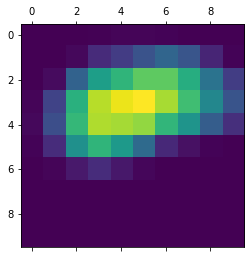

In [51]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

**Superimposing the heatmap on the original picture**

In [57]:
img = load_img(img_path)
img = img_to_array(img)

heatmap = np.uint8(255 * heatmap)

jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

jet_heatmap = array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = img_to_array(jet_heatmap)

superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = array_to_img(superimposed_img)

save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)